# Guided Backpropagation

Guided backpropagation is a combination of the gradient and deconvolution class saliency methods. The deconvolution method discussed in [Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps](https://arxiv.org/abs/1312.6034), was shown to be equivalent to a backward pass through the network, except for its interaction with the relu layer. The negative gradient values would be zeroed by relu, but the gradient values coming from negative input image values were not zeroed. Guided backpropagation method adapts this idea by zeroing both negative gradients and gradients coming from negative input values. We will implement this method by introducing a new relu layer called guided relu. Unfortunately guided relu performs poorly when training, so the model will first be trained with relu layers, then the relu layers will be swapped out for the guided relu layers when evaluating the saliency maps. There is no obvious way to swap layers in flax, so instead we will define a new model with the same architecture but guided relu inplace of relu layers.  

For more technical information on the guided backpropagation attribution method see: [1] [Striving for Simplicity: The All Convolutional Net](https://arxiv.org/abs/1412.6806)


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import custom_vjp
import flax.linen as nn
import jax
from jax import random
from jax import grad
from keras.utils import data_utils

2022-11-08 09:31:54.153704: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-08 09:31:54.798985: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64:
2022-11-08 09:31:54.799269: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64:
2022-11-08 09:31:54.799278: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned a

### Load training data
Check if the training data exists. If not, automatically download it.

In [2]:
data_dir = os.path.abspath("./digit-recognizer")
os.makedirs(data_dir, exist_ok=True)
train_data_path = f"{data_dir}/train.zip"
train_data_url = "https://huggingface.co/datasets/ChristianOrr/mnist/resolve/main/train.zip"

if not os.path.exists(train_data_path):
    print("Downloading training data...")
    data_utils.get_file(
        train_data_path, 
        train_data_url, 
        extract=True, 
        cache_dir=data_dir
        )

data_df = pd.read_csv('./digit-recognizer/datasets/train.csv')

In [3]:
val_size = 1000
# Only shuffle training data
np.random.shuffle(data_df[val_size:].values)
m, n = data_df.shape
Y = jnp.array(data_df["label"])
data_df = data_df.drop("label", axis=1)
X = jnp.array(data_df)


X_train = X[val_size:]
X_train = X_train / 255.
Y_train = Y[val_size:]

X_val = X[:val_size]
X_val = X_val / 255.
Y_val = Y[:val_size]

### Define the classification model

In [91]:
class _forward_fn(nn.Module):

    @nn.compact
    def __call__(self, x):
        batch_size = x.shape[0]
        # Unflatten for the convolution layers
        x = x.reshape(batch_size, 28, 28, 1)
        conv_layers = nn.Sequential([
            nn.Conv(features=16, kernel_size=(3, 3), padding="VALID", use_bias=False), jax.nn.relu,
            nn.Conv(features=32, kernel_size=(3, 3), padding="VALID", use_bias=False), jax.nn.relu,   
        ])
        x = conv_layers(x)
        # Flatten for dense layer
        x = x.reshape((batch_size, -1))
        x = nn.Dense(10)(x)
        return jax.nn.softmax(x)

# Create eh model object
forward_fn = _forward_fn()
# Display the model details
dummy_x = X_train[:5]
rng_key = random.PRNGKey(64)
initial_params = forward_fn.init(rng_key, dummy_x)
print(forward_fn.tabulate(rng_key, dummy_x))


                              _forward_fn Summary                               
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ path         ┃ module      ┃ inputs         ┃ outputs       ┃ params         ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│              │ _forward_fn │ float32[5,784] │ float32[5,10] │                │
├──────────────┼─────────────┼────────────────┼───────────────┼────────────────┤
│ Sequential_0 │ Sequential  │ float32[5,28,… │ float32[5,24… │                │
├──────────────┼─────────────┼────────────────┼───────────────┼────────────────┤
│ Conv_0       │ Conv        │ float32[5,28,… │ float32[5,26… │ kernel:        │
│              │             │                │               │ float32[3,3,1… │
│              │             │                │               │                │
│              │             │                │               │ 144 (576 B)    │
├──────────────┼───────────

### Define the loss function and update method

In [92]:
def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[..., None] == jnp.arange(k), dtype)

def loss_fn(params, X, Y):
    logits = forward_fn.apply(params, X)
    one_hot_Y = one_hot(Y, 10)
    loss = -jnp.sum(one_hot_Y * jnp.log(logits)) / m
    return loss

def update_rule(param, update):
    return param - 0.1 * update

def update_params(params, alpha, X, Y):
    grads = grad(loss_fn, argnums=0)(params, X, Y)
    params = jax.tree_util.tree_map(update_rule, params, grads)
    return params


### Train the model

In [93]:
def get_predictions(logits):
    return jnp.argmax(logits, axis=1)

def get_accuracy(predictions, Y):
    return jnp.mean(predictions == Y)

def gradient_descent(X, Y, batch_size, alpha, epochs):
    dataset_size = len(X)
    steps_per_epoch = dataset_size // batch_size

    rng = jax.random.PRNGKey(42)
    params = forward_fn.init(rng, X[0: batch_size, :])

    for epoch in range(epochs):
        dataset_step = epoch % steps_per_epoch
        dataset_index = dataset_step * batch_size
        input = X[dataset_index: dataset_index + batch_size, :]
        label = Y[dataset_index: dataset_index + batch_size, ...]
        params = update_params(params, alpha, input, label)
        if epoch % 10 == 0:
            print("Iteration: ", epoch)
            logits = forward_fn.apply(params, input)
            predictions = get_predictions(logits)
            print(get_accuracy(predictions, label))
    return params

In [94]:
params = gradient_descent(X_train, Y_train, 2000, 0.10, 200)

Iteration:  0
0.120000005
Iteration:  10
0.735
Iteration:  20
0.79350007
Iteration:  30
0.82100004
Iteration:  40
0.84050006
Iteration:  50
0.85850006
Iteration:  60
0.86550003
Iteration:  70
0.873
Iteration:  80
0.87450004
Iteration:  90
0.87950003
Iteration:  100
0.88000005
Iteration:  110
0.88600004
Iteration:  120
0.882
Iteration:  130
0.88900006
Iteration:  140
0.887
Iteration:  150
0.89300007
Iteration:  160
0.89050007
Iteration:  170
0.89750004
Iteration:  180
0.89500004
Iteration:  190
0.89800006


### Create Guided Relu

The key to the guided backprop method is the guided relu layer. We will start by defining this layer. The difficult part of this layer is getting access to the gradients and manipulating them during the backward pass. Fortunately Jax provides a way to overide the differentiation operations, more details on that here: [Custom derivative rules for JAX-transformable Python functions](https://jax.readthedocs.io/en/latest/notebooks/Custom_derivative_rules_for_Python_code.html). The most important part of the layer is in the backward function called guided_relu_bwd. We start by taking the derivative of relu, which outputs 1 of the input is > 1 and outputs 0 otherwise. The relu derivative is then applied to both the inputs, called residual, and gradients, called grad in the function. This provides us with 0 or 1 variable which act like gates, hence the variable names grad_gate and residual_gate. The gates are then multiplied by grad to give us the final output. Alternative implementations of guided relu are available in Pytorch and Tensorflow here: [Guided Backpropagation with PyTorch and TensorFlow](https://www.coderskitchen.com/guided-backpropagation-with-pytorch-and-tensorflow/).

In [ ]:
@custom_vjp
def guided_relu(x):
    return jax.nn.relu(x)

def guided_relu_fwd(x):
    residual = x
    primal = guided_relu(x)

    return primal, residual

def guided_relu_bwd(residual, grad):
    # Derivative of relu is 1 for values > 0 and 0 otherwise
    # Using relu devivative for both residuals and grads
    grad_gate = jnp.float32(grad > 0)
    residual_gate = jnp.float32(residual > 0)
    output = residual_gate * grad_gate * grad
    return (output, ) 

guided_relu.defvjp(guided_relu_fwd, guided_relu_bwd)


### Demonstrate guided relu on sin

To demonstrate how guided relu works and if its working we will visualize its impact on the sin function. We start with a 1D input vector from -5 to 5. The input is then fed into sin and the derivative of sin and shown below. This demonstates how the output looks with no alterations.

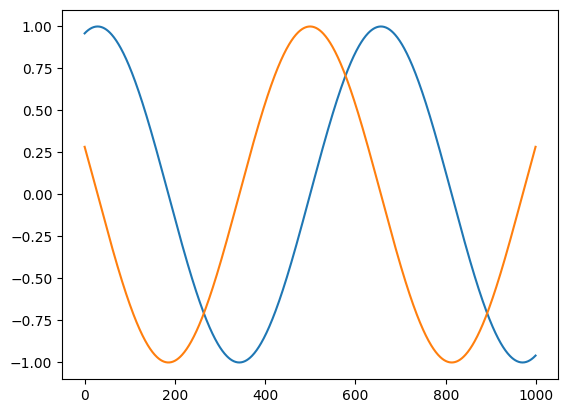

In [ ]:
input_vector = jnp.linspace(-5, 5, 1000)

plt.plot(jnp.sin(input_vector))
plt.plot(jax.vmap(grad(jnp.sin))(input_vector))

Now we alter the input values by passing them first to relu. The first half of the inputs were negative. This caused the first half of the sin and derivative of sin outputs to be 0, as shown below. 

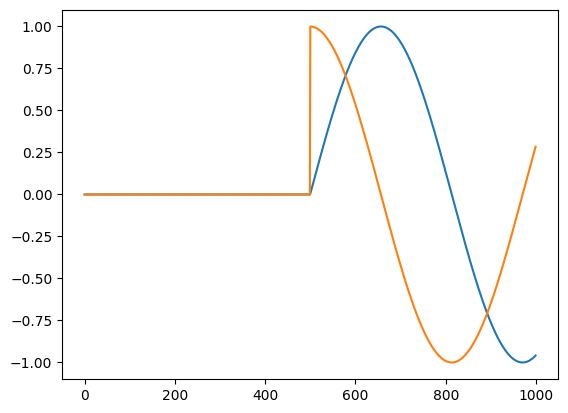

In [ ]:
def relu_sin(x):
    x = jax.nn.relu(x)
    return jnp.sin(x)

plt.plot(relu_sin(input_vector))
plt.plot(jax.vmap(grad(relu_sin))(input_vector))

Now we replace relu with guided relu. The output of the sin function is unchanged from standard relu, but now the gradients of sin have been altered further. In addition to the gradients being 0 for all negative input values, they are also 0 in places where the gradients would be zero. This demonstrates guided relu is working as desired. 

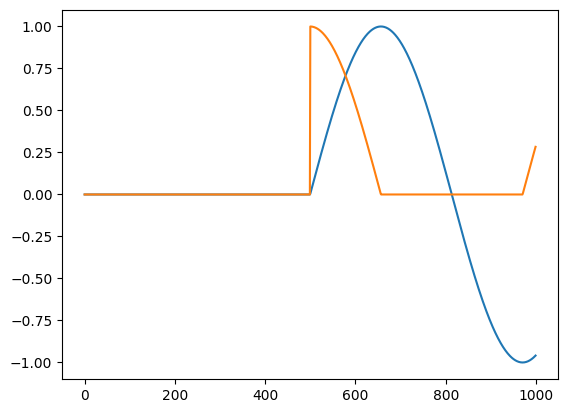

In [ ]:
def guided_relu_sin(x):
    x = guided_relu(x)
    return jnp.sin(x)

plt.plot(guided_relu_sin(input_vector))
plt.plot(jax.vmap(grad(guided_relu_sin))(input_vector))

### Create the guided model

Now that we have the guided relu layers we can swap them with the relu layers in the classification model. The model architecture is identical to the one trained previously so we can use its trained parameters.

In [95]:
class _guided_forward_fn(nn.Module):

    @nn.compact
    def __call__(self, x):
        batch_size = x.shape[0]
        # Unflatten for the convolution layers
        x = x.reshape(batch_size, 28, 28, 1)
        conv_layers = nn.Sequential([
            nn.Conv(features=16, kernel_size=(3, 3), padding="VALID", use_bias=False), guided_relu,
            nn.Conv(features=32, kernel_size=(3, 3), padding="VALID", use_bias=False), guided_relu,   
        ])
        x = conv_layers(x)
        # Flatten for dense layer
        x = x.reshape((batch_size, -1))
        x = nn.Dense(10)(x)
        return jax.nn.softmax(x)

# Create eh model object
guided_forward_fn = _guided_forward_fn()
# Display the model details
dummy_x = X_train[:5]
rng_key = random.PRNGKey(64)
initial_params = guided_forward_fn.init(rng_key, dummy_x)
print(guided_forward_fn.tabulate(rng_key, dummy_x))


                           _guided_forward_fn Summary                           
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ path         ┃ module        ┃ inputs        ┃ outputs       ┃ params        ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│              │ _guided_forw… │ float32[5,78… │ float32[5,10] │               │
├──────────────┼───────────────┼───────────────┼───────────────┼───────────────┤
│ Sequential_0 │ Sequential    │ float32[5,28… │ float32[5,24… │               │
├──────────────┼───────────────┼───────────────┼───────────────┼───────────────┤
│ Conv_0       │ Conv          │ float32[5,28… │ float32[5,26… │ kernel:       │
│              │               │               │               │ float32[3,3,… │
│              │               │               │               │               │
│              │               │               │               │ 144 (576 B)   │
├──────────────┼───────────

### Create new loss function with guided model

A new loss function containing the model with guided relu layers is required when performing gradient calculations for the attribution saliency maps.

In [96]:
def guided_loss_fn(params, X, Y):
    logits = guided_forward_fn.apply(params, X)
    one_hot_Y = one_hot(Y, 10)
    loss = -jnp.sum(one_hot_Y * jnp.log(logits)) / m
    return loss

### Display predictions and saliency maps

The gradients are calculated with the new guided loss function. The gradients are then normalized in the standard way for visualization.

In [97]:
def make_predictions(X, params):
    logits = forward_fn.apply(params, X)
    predictions = get_predictions(logits)
    return predictions

def prep_image(image):
    # Normalize the gradient values to be between 0-1
    max_val= np.max(image)
    min_val = np.min(image)
    image = (image - min_val) / (max_val - min_val)
    # Convert the grads to uint8 for displaying
    image = np.uint8(image * 255)
    return image   

def display_prediction(index, params):
    current_image = X_val[None, index]
    prediction = make_predictions(X_val[None, index], params)

    label = Y_val[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    display_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(display_image, interpolation='nearest')
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    
    attributions = grad(guided_loss_fn, argnums=1)(params, current_image, label)[0]
    attributions = attributions.reshape((28, 28))
    attributions = prep_image(attributions)

    plt.gray()
    plt.imshow(attributions, interpolation='nearest')
    plt.axis('off')
    plt.title("Saliency Map")
    plt.show()

Prediction:  [1]
Label:  1


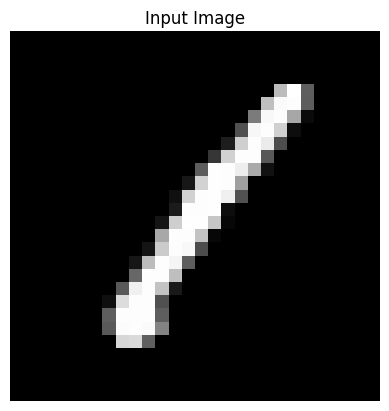

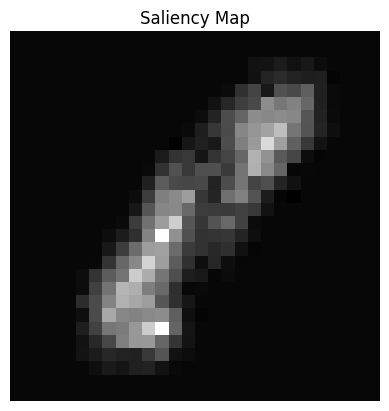

Prediction:  [2]
Label:  4


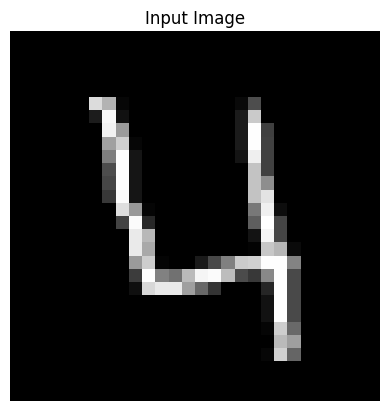

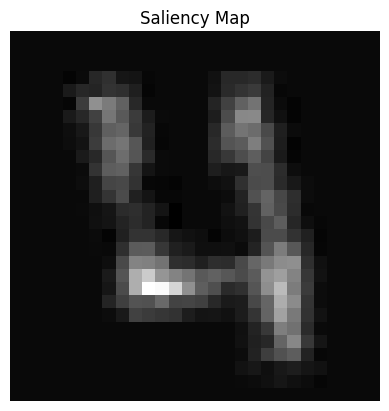

Prediction:  [0]
Label:  0


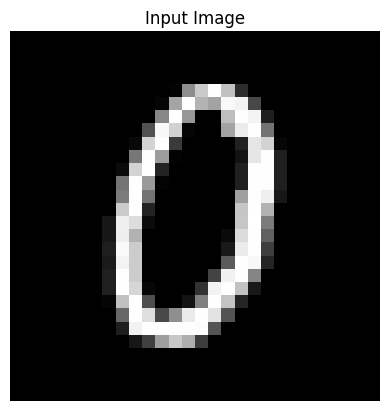

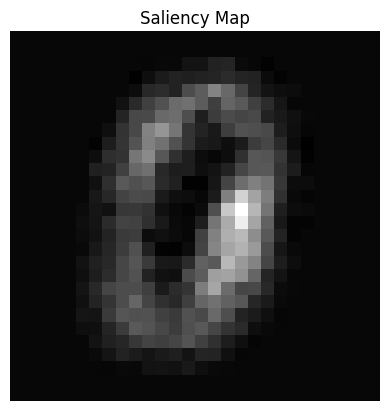

Prediction:  [5]
Label:  5


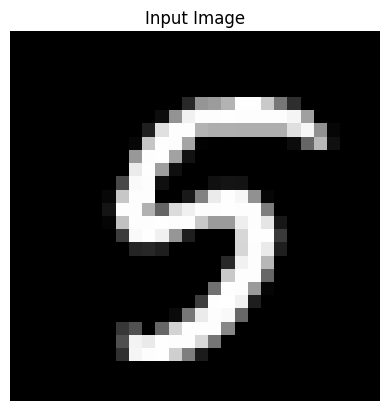

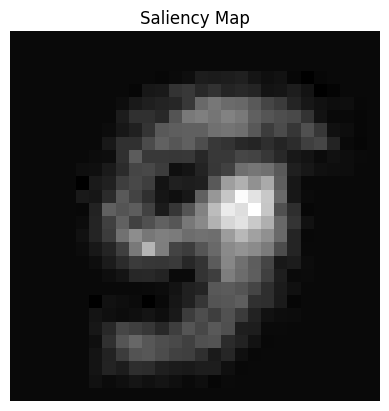

Prediction:  [8]
Label:  8


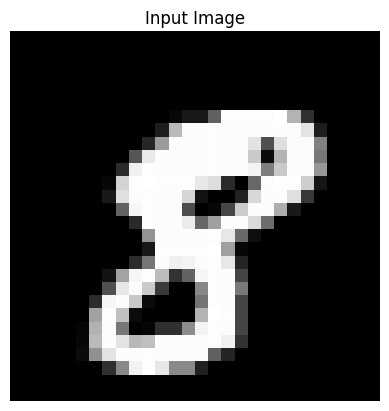

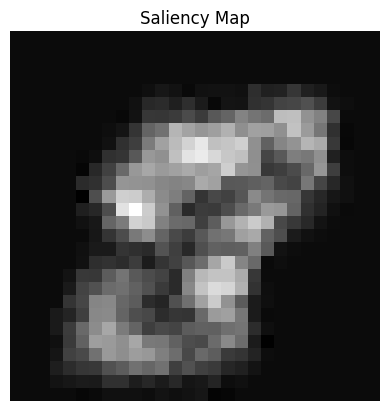

Prediction:  [7]
Label:  7


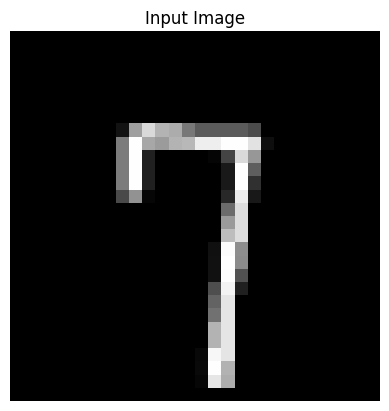

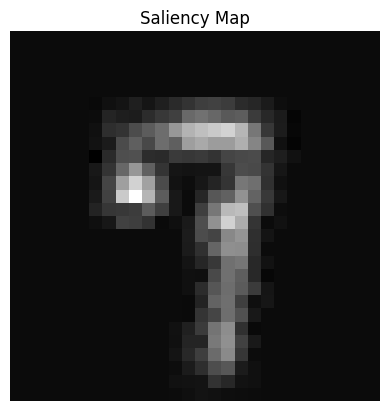

In [98]:
display_prediction(0, params)
display_prediction(3, params)
display_prediction(5, params)
display_prediction(8, params)
display_prediction(10, params)
display_prediction(50, params)